# Проект "Промышленность"

Чтобы оптимизировать производственные расходы, металлургический комбинат  решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 

План исследования: 
1. Загрузка и первичный осмотр данных
2. Исследовательский анализ и предобработка данных. Генерация новых признаков.
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5.  Подготовка данных: разделение данных на 2 выборки. Стандартизация. 
6.  Обучение моделей машинного обучения:
     1. Ridge
     2. Lasso
     3. LGBMBoost
     4. XGBoost
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

Импорт необходимых библиотек

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

## Загрузка данных

### Данные об электродах

In [2]:
try: 
    df_arc = pd.read_csv('data_arc_new.csv')
except:
    df_arc = pd.read_csv('/datasets/data_arc_new.csv')
df_arc.head(2)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438


In [3]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [5]:
len(df_arc['key'].unique())

3214

* Каждый ковш нагревается несколько раз. В датафрейме указано время начало и конца нагревания, а также активная и реактивная мощность электродов для каждого нагревания.
* Датафрейм содержит информацию о 3214 ковшах
* В датфрейме нет пропущеных значений.
* Судя по статистике датафрейма,  признак "Реактивная мощность" содержит выбросы (некорректо зафиксированные данные, можность не может быть ниже нуля и отличаться на 3 порядка). 

### Данные о подаче сыпучих материалов (объём)

In [6]:
try:
    df_bulk = pd.read_csv('data_bulk_new.csv')
except:
    df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')    
df_bulk.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0


In [7]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [8]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


* Данные содержат много пропусков. Они означают, что данного материала добавлено не было
* Некоторые столбцы малоинформативны, т.к. содержат менее 1% ненулевых значений: Bulk 2, Bulk 7, Bulk 8, Bulk 13

### Данные о подаче сыпучих материалов (время)

In [9]:
try:
    df_bulk_time = pd.read_csv('data_bulk_time_new.csv')
except:
    df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
df_bulk_time.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39


In [10]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


* Данные из этой таблицы малоинформативны и в ряде аспектов поторяют данные из предыдущего датафрейма. 

### Данные о продувке сплава газом

In [11]:
try:
    df_gas = pd.read_csv('data_gas_new.csv')
except:
    df_gas = pd.read_csv('/datasets/data_gas_new.csv')
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [12]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [13]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


* В представленном датафрейме количество наблюдений больше, чем в предыдущих, пропусков нет

### Результаты измерения температуры

In [14]:
try:
    df_t = pd.read_csv('data_temp_new.csv')
except:    
    df_t = pd.read_csv('/datasets/data_temp_new.csv')
df_t.head(2)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0


In [15]:
df_t = df_t.dropna()
df_t.shape

(14665, 3)

In [16]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           14665 non-null  int64  
 1   Время замера  14665 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 458.3+ KB


In [17]:
df_t.describe()

,key,Температура
count,14665.000000,14665.000000
mean,1325.484214,1590.722741
std,787.375969,20.394381
min,1.000000,1191.000000
25%,654.000000,1580.000000
50%,1314.000000,1590.000000
75%,1963.000000,1599.000000
max,3241.000000,1705.000000


In [18]:
df_t['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241], dtype=int64)

* Конечная температура сплава является целевым признаком
* Датафрейм содержит пропуски в признаке температуры, которые невозможно заполнить. Соответствующие строки были удалены. 

### Данные о проволочных материалах (объём)

In [19]:
try:
    df_wire = pd.read_csv('data_wire_new.csv')
except:
    df_wire = pd.read_csv('/datasets/data_wire_new.csv')
df_wire.head(2)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [21]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


* Данные содержат много пропусков. Они означают, что данного материала добавлено не было
* Большинство признаков малоинформативны: Wire 3 - Wire 9

### Данные о проволочных материалах (время)

In [22]:
try:
    df_wire_time = pd.read_csv('data_wire_time_new.csv')
except:
    df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
df_wire_time.head(2)    

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


* Данные из этой таблицы малоинформативны и в ряде аспектов поторяют данные из предыдущего датафрейма. 

## Исследовательский анализ и предобработка данных

Для исследования ящиком с усами возьмём не 1,5, а 3 межквартильных размаха

### Данные об электродах

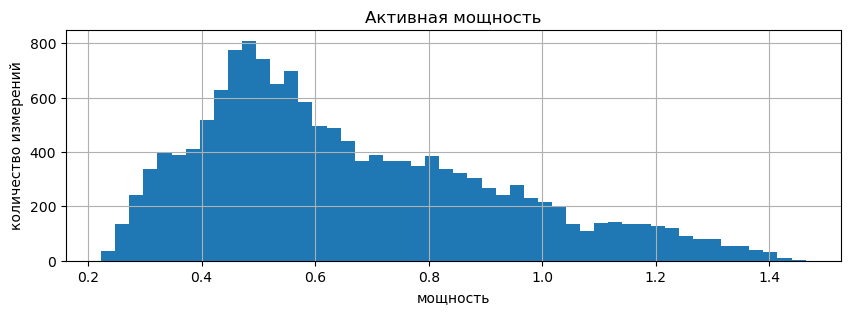

In [24]:
df_arc['Активная мощность'].hist(bins=50, figsize=(10, 3))
plt.title('Активная мощность')
plt.xlabel('мощность')
plt.ylabel('количество измерений')
plt.show()

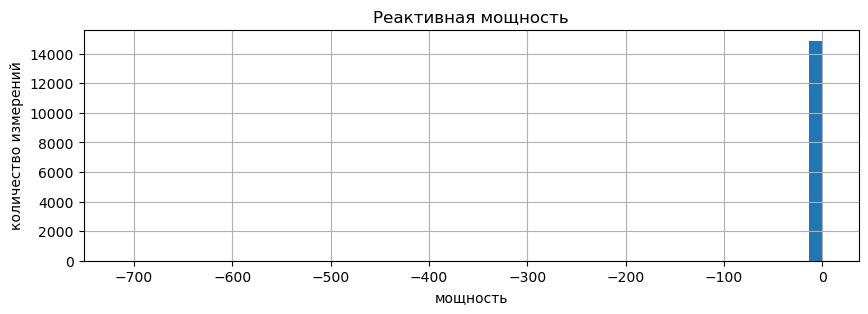

In [25]:
df_arc['Реактивная мощность'].hist(bins=50, figsize=(10, 3))
plt.title('Реактивная мощность')
plt.xlabel('мощность')
plt.ylabel('количество измерений')
plt.show()

In [26]:
(df_arc['Реактивная мощность'] < 0).sum()

1

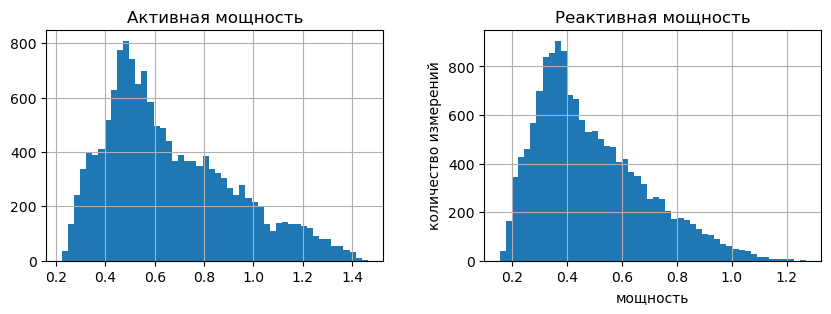

In [30]:
df_arc.drop(index=df_arc.loc[df_arc['Реактивная мощность'] < 0].index, columns='key').hist(bins=50, figsize=(10, 3))
plt.title('Реактивная мощность')
plt.xlabel('мощность')
plt.ylabel('количество измерений')
plt.show()

**Полная мощность**

In [31]:
df_arc['Полная мощность'] = (df_arc['Активная мощность'] ** 2 + df_arc['Реактивная мощность'] ** 2) ** 0.5

In [32]:
df_arc_mean = df_arc.drop(columns=['Начало нагрева дугой','Конец нагрева дугой']).groupby('key').mean().reset_index()


In [33]:
df_arc_mean.head()

,key,Активная мощность,Реактивная мощность,Полная мощность
0,1,0.607346,0.428564,0.743747
1,2,0.534852,0.363339,0.647087
2,3,0.812728,0.587491,1.003845
3,4,0.676622,0.514248,0.850010
4,5,0.563238,0.421998,0.704245


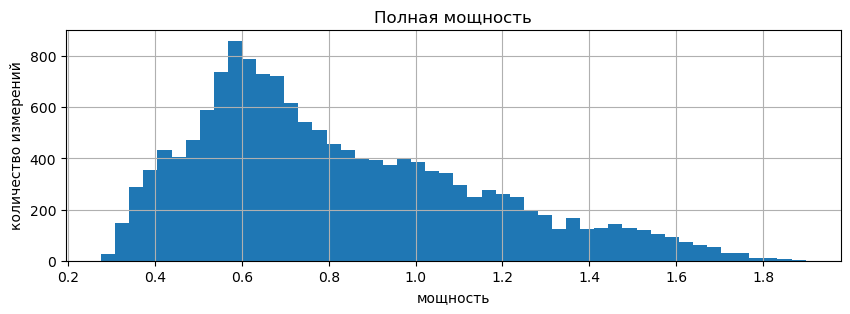

In [34]:
df_arc.drop(df_arc.loc[df_arc['Реактивная мощность'] < 0].index)['Полная мощность'].hist(bins=50, figsize=(10, 3))
plt.title('Полная мощность')
plt.xlabel('мощность')
plt.ylabel('количество измерений')
plt.show()

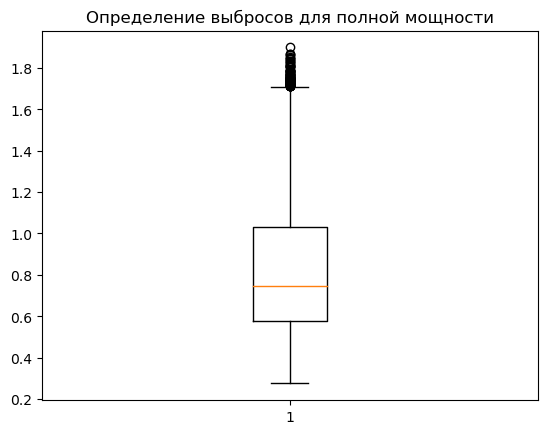

In [35]:
plt.boxplot(df_arc.drop(df_arc.loc[df_arc['Реактивная мощность'] < 0].index)['Полная мощность'])
plt.title('Определение выбросов для полной мощности')
plt.show()

Среди выбросов нет аномально выделяющихся значений, значит, избавляться от этой части информации нельзя. 


**Время нагрева дугой**

In [36]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])

In [37]:
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])

In [38]:
df_arc['Время нагрева дугой'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой'])\
                                .apply(lambda x: x.total_seconds())

In [39]:
df_arc.loc[:, ['key','Время нагрева дугой']].head(10)

,key,Время нагрева дугой
0,1,228.0
1,1,185.0
2,1,172.0
3,1,365.0
4,1,148.0
5,2,137.0
6,2,338.0
7,2,126.0
8,2,210.0
9,3,280.0


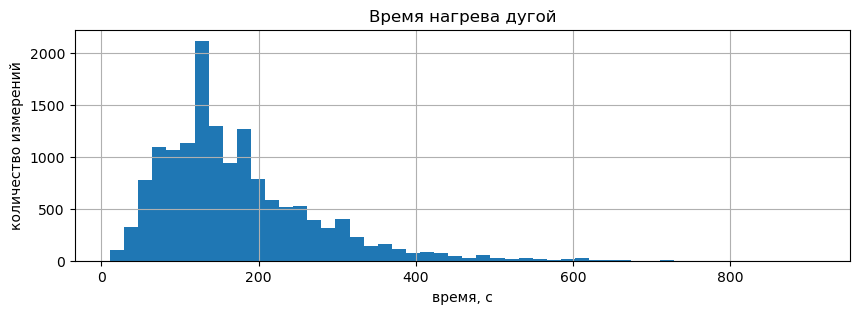

In [40]:
df_arc['Время нагрева дугой'].hist(bins=50, figsize=(10, 3))
plt.title('Время нагрева дугой')
plt.xlabel('время, с')
plt.ylabel('количество измерений')
plt.show()

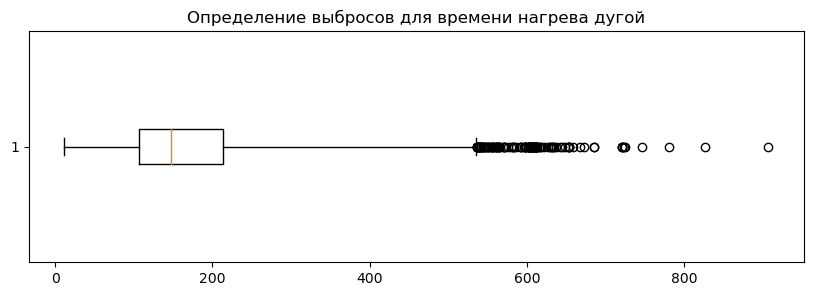

In [41]:
plt.figure(figsize=(10, 3))
plt.boxplot(df_arc['Время нагрева дугой'], vert=False, whis=3)
plt.title('Определение выбросов для времени нагрева дугой')
plt.show()

Теоретически, такое время возможно

**Совершенная работа**

In [42]:
df_arc['Работа'] = df_arc['Время нагрева дугой'] * df_arc['Полная мощность']

In [43]:
df_arc_new = df_arc.groupby('key')[['Время нагрева дугой', 'Работа', 'Полная мощность']].sum().reset_index()
df_arc_new.head()

,key,Время нагрева дугой,Работа,Полная мощность
0,1,1098.0,770.282114,3.718736
1,2,811.0,481.760005,2.588349
2,3,655.0,722.837668,5.019223
3,4,741.0,683.455597,3.400038
4,5,869.0,512.169934,2.816980


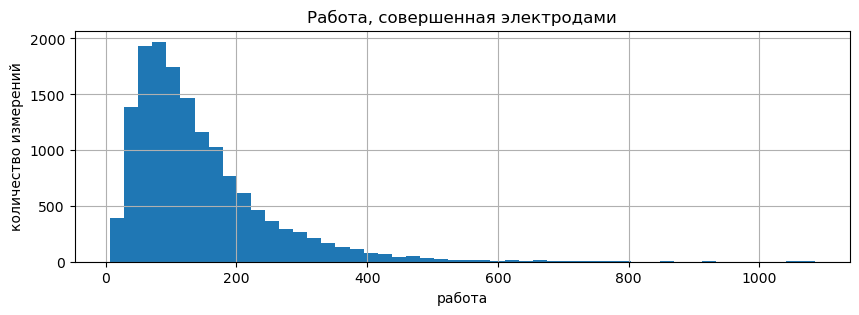

In [44]:
df_arc['Работа'].drop(df_arc.loc[df_arc['Реактивная мощность'] < 0].index).hist(bins=50, figsize=(10, 3))
plt.title('Работа, совершенная электродами')
plt.xlabel('работа')
plt.ylabel('количество измерений')
plt.show()

теоретически, такое время возможно

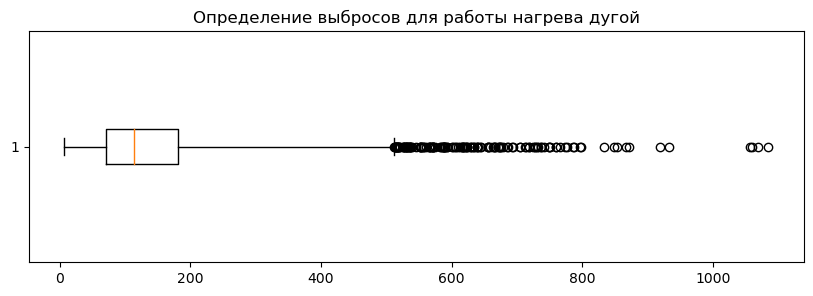

In [45]:
plt.figure(figsize=(10, 3))
plt.boxplot(df_arc['Работа'].drop(df_arc.loc[df_arc['Реактивная мощность'] < 0].index), vert=False, whis=3)
plt.title('Определение выбросов для работы нагрева дугой')
plt.show()

In [46]:
df_arc_new.shape

(3214, 4)

Впоследствии данные будут объединяться пересечением, и в итоговую выборку войдут ковши с полными и верными данными.

In [49]:
df_arc_new

,key,Время нагрева дугой,Работа,Полная мощность
0,1,1098.0,770.282114,3.718736
1,2,811.0,481.760005,2.588349
2,3,655.0,722.837668,5.019223
3,4,741.0,683.455597,3.400038
4,5,869.0,512.169934,2.816980
...,...,...,...,...
3209,3237,909.0,630.503534,3.250657
3210,3238,546.0,286.052252,1.723937
3211,3239,1216.0,941.538764,6.014480
3212,3240,839.0,657.439848,4.082920


### Данные о подаче сыпучих материалов 

In [50]:
df_bulk['bulk_count'] = df_bulk.drop(columns='key').notna().sum(axis=1)

In [51]:
df_bulk.notna().sum()

key           3129
Bulk 1         252
Bulk 2          22
Bulk 3        1298
Bulk 4        1014
Bulk 5          77
Bulk 6         576
Bulk 7          25
Bulk 8           1
Bulk 9          19
Bulk 10        176
Bulk 11        177
Bulk 12       2450
Bulk 13         18
Bulk 14       2806
Bulk 15       2248
bulk_count    3129
dtype: int64

Пропуск значений в количестве сыпучих материалов обозначает отсутствие этой добавки

In [52]:
df_bulk = df_bulk.fillna(0)

In [53]:
df_bulk = df_bulk.astype('float32')

In [54]:
df_bulk['bulk_sum'] = (df_bulk['Bulk 1'] + df_bulk['Bulk 2'] + df_bulk['Bulk 3'] + df_bulk['Bulk 4'] 
                       + df_bulk['Bulk 5'] + df_bulk['Bulk 6'] + df_bulk['Bulk 7'] + df_bulk['Bulk 8'] 
                       + df_bulk['Bulk 9'] + df_bulk['Bulk 10'] + df_bulk['Bulk 11'] + df_bulk['Bulk 12'] 
                       + df_bulk['Bulk 13'] + df_bulk['Bulk 14'] + df_bulk['Bulk 15'])


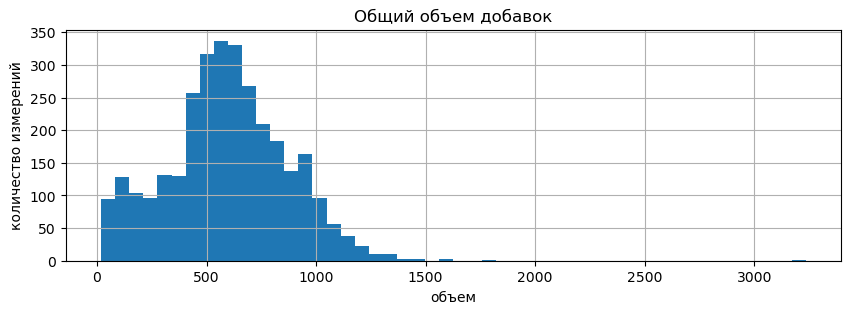

In [55]:
df_bulk['bulk_sum'].hist(bins=50, figsize=(10, 3))
plt.title('Общий объем добавок')
plt.xlabel('объем')
plt.ylabel('количество измерений')
plt.show()

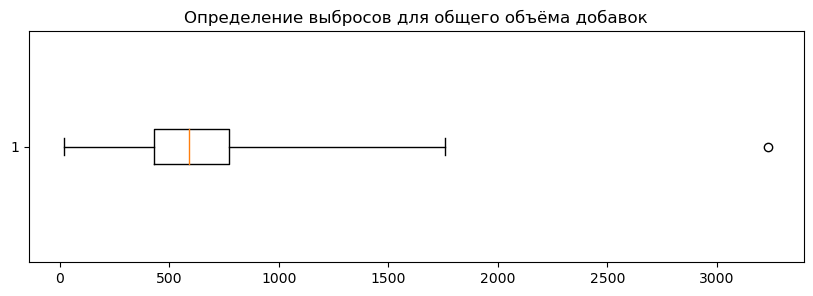

In [56]:
plt.figure(figsize=(10, 3))
plt.boxplot(df_bulk['bulk_sum'], vert=False, whis=3)
plt.title('Определение выбросов для общего объёма добавок')
plt.show()

In [57]:
df_bulk = df_bulk.drop(df_bulk.loc[df_bulk['bulk_sum'] > 2000].index)

In [58]:
df_bulk = df_bulk.drop(columns=['Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13'])

In [59]:
df_bulk.head()

,key,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,bulk_count,bulk_sum
0,1.0,0.0,43.0,0.0,206.0,150.0,154.0,4.0,553.0
1,2.0,0.0,73.0,0.0,206.0,149.0,154.0,4.0,582.0
2,3.0,0.0,34.0,0.0,205.0,152.0,153.0,4.0,544.0
3,4.0,0.0,81.0,0.0,207.0,153.0,154.0,4.0,595.0
4,5.0,0.0,78.0,0.0,203.0,151.0,152.0,4.0,584.0


В данных не учитываем аномально большой объем добавок

### Объём подаваемого газа 

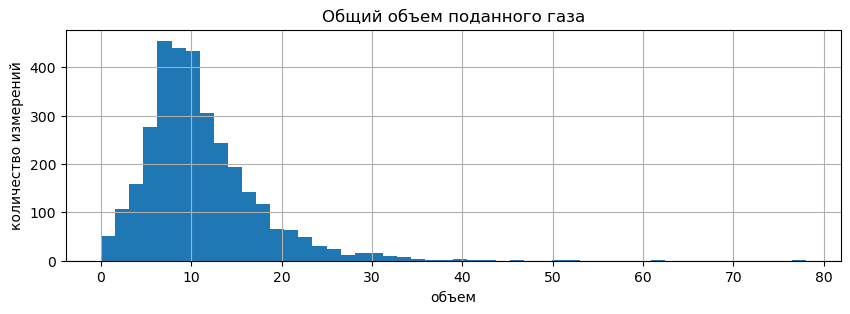

In [60]:
df_gas['Газ 1'].hist(bins=50, figsize=(10, 3))
plt.title('Общий объем поданного газа')
plt.xlabel('объем')
plt.ylabel('количество измерений')
plt.show()

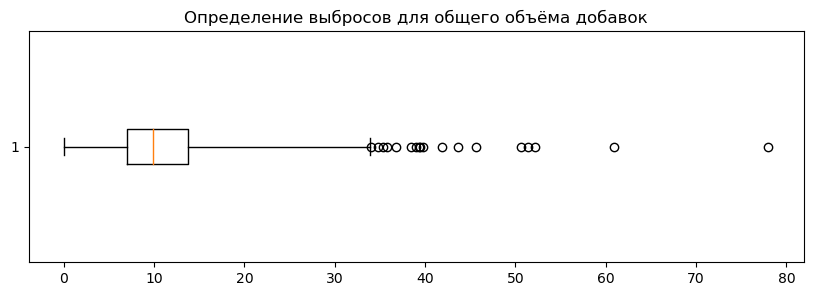

In [61]:
plt.figure(figsize=(10, 3))
plt.boxplot(df_gas['Газ 1'], vert=False, whis=3)
plt.title('Определение выбросов для общего объёма добавок')
plt.show()

Большие значения объема поданного газа могут  соответствовать большому времени нагрева. 

In [62]:
(df_gas['Газ 1'] > 60).sum()

2

In [63]:
df_gas = df_gas.loc[df_gas['Газ 1'] < 50]
df_gas.shape

(3234, 2)

### Результаты измерения температуры

In [64]:
df_t.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

Отбросим ковши, у которых менише 2 измерений температуры, то есть нет начальной и конечной

In [65]:
df_t_grouped = df_t.groupby('key')['Время замера'].count().reset_index().rename(columns={'Время замера':'Количество замеров'})
df_t_grouped.head()

,key,Количество замеров
0,1,6
1,2,5
2,3,6
3,4,5
4,5,5


In [66]:
(df_t_grouped['Количество замеров'] < 2).sum()

741

In [67]:
df_t_grouped = df_t_grouped.loc[df_t_grouped['Количество замеров'] >= 2]
df_t_grouped.shape

(2475, 2)

Удалены ковши, имеющие только одно измерение температуры

In [68]:
df_tmax = df_t.groupby('key')['Время замера'].max().reset_index()
df_tmax.head()

,key,Время замера
0,1,2019-05-03 11:30:38
1,2,2019-05-03 11:55:09
2,3,2019-05-03 12:35:57
3,4,2019-05-03 12:59:47
4,5,2019-05-03 13:36:39


In [69]:
df_tmin = df_t.groupby('key')['Время замера'].min().reset_index()

In [70]:
df_temp_max = df_t.merge(df_tmax, on='Время замера').drop(columns=['key_y', 'Время замера']).rename(columns={'key_x':'key'})\
                  .merge(df_t_grouped, on='key')
df_temp_max.head()

,key,Температура,Количество замеров
0,1,1613.0,6
1,2,1602.0,5
2,3,1599.0,6
3,4,1625.0,5
4,5,1602.0,5


In [71]:
df_temp_max.shape                                 

(2475, 3)

Проверим, соответствует ли измеренная температура темпертуре плавления стали и удалим лишние ковши с неправильно измеренной температурой

In [72]:
(df_temp_max['Температура'] < 1400).sum()

0

In [73]:
df_temp_max = df_temp_max.loc[df_temp_max['Температура'] > 1400]

In [74]:
df_temp_max.shape

(2475, 3)

In [75]:
df_temp_min = df_t.merge(df_tmin, on='Время замера').drop(columns='Время замера')\
                  .drop(columns='key_y').rename(columns={'key_x':'key'})\
                  .rename(columns={'Температура': 'Начальная температура'})
df_temp_min.head()

,key,Начальная температура
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0


In [76]:
(df_temp_min['Начальная температура'] < 1400).sum()

5

In [77]:
df_temp_min = df_temp_min.loc[df_temp_min['Начальная температура'] > 1400]

In [78]:
df_temp_min.shape

(3211, 2)

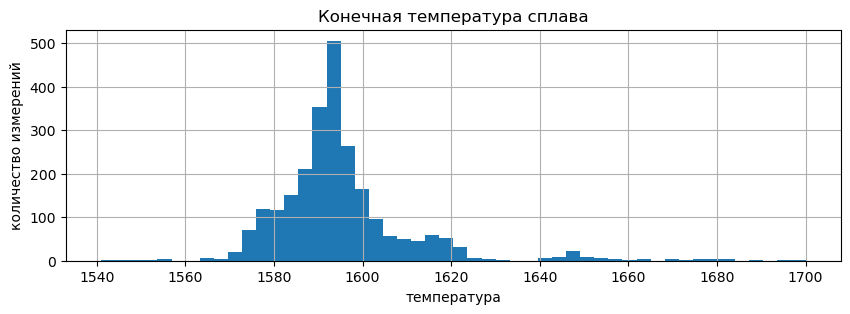

In [79]:
df_temp_max['Температура'].hist(bins=50, figsize=(10, 3))
plt.title('Конечная температура сплава')
plt.xlabel('температура')
plt.ylabel('количество измерений')
plt.show()

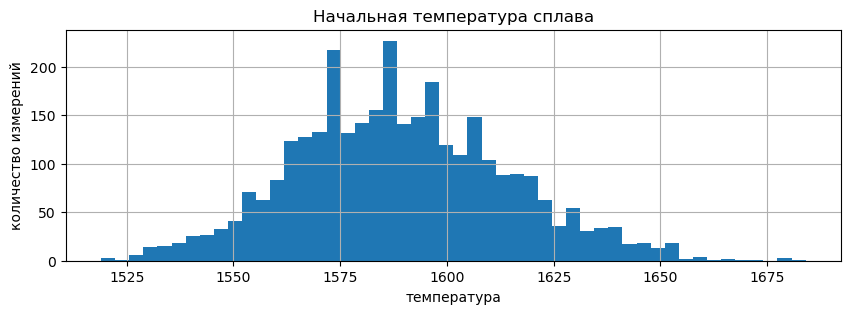

In [80]:
df_temp_min['Начальная температура'].hist(bins=50, figsize=(10, 3))
plt.title('Начальная температура сплава')
plt.xlabel('температура')
plt.ylabel('количество измерений')
plt.show()

### Данные о проволочных материалах (объём)

In [82]:
df_wire = df_wire.fillna(0)

In [83]:
df_wire['wire_sum'] = df_wire['Wire 1'] + df_wire['Wire 2'] + df_wire['Wire 3'] +\
                       df_wire['Wire 4'] + df_wire['Wire 5'] + df_wire['Wire 6'] +\
                       df_wire['Wire 7'] + df_wire['Wire 8'] + df_wire['Wire 9']

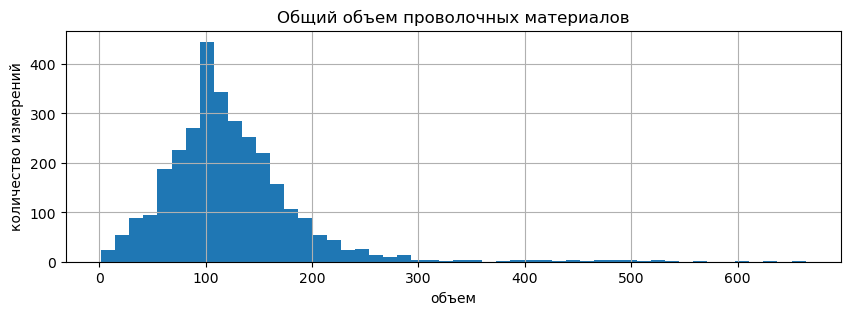

In [84]:
df_wire['wire_sum'].hist(bins=50, figsize=(10, 3))
plt.title('Общий объем проволочных материалов')
plt.xlabel('объем')
plt.ylabel('количество измерений')
plt.show()

In [85]:
df_wire['wire_count'] = df_wire.apply(lambda x: (x > 0).sum() - 1, axis='columns')

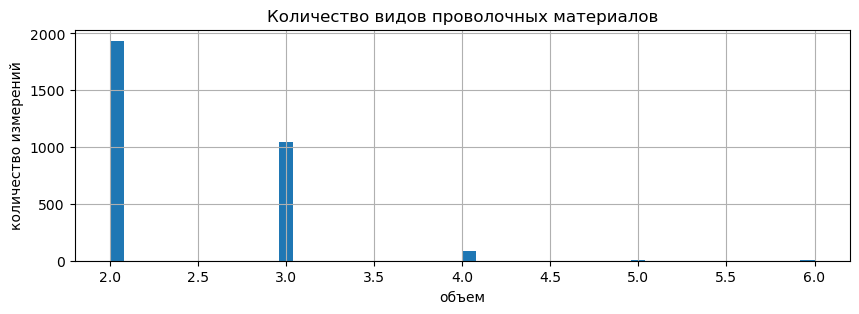

In [86]:
df_wire['wire_count'].hist(bins=50, figsize=(10, 3))
plt.title('Количество видов проволочных материалов')
plt.xlabel('объем')
plt.ylabel('количество измерений')
plt.show()

In [87]:
df_wire = df_wire[['key', 'wire_sum', 'wire_count', 'Wire 1', 'Wire 2']]

In [88]:
df_wire.head()

,key,wire_sum,wire_count,Wire 1,Wire 2
0,1,60.059998,2,60.059998,0.00000
1,2,96.052315,2,96.052315,0.00000
2,3,91.160157,2,91.160157,0.00000
3,4,89.063515,2,89.063515,0.00000
4,5,98.352796,3,89.238236,9.11456


## Объединение данных и анализ признаков

In [89]:
df = df_temp_max.merge(df_bulk, on='key', how='inner')\
               .merge(df_temp_min, on='key', how='inner')\
               .merge(df_arc_new, on='key', how='inner')\
               .merge(df_gas, on='key', how='inner')\
               .merge(df_wire, on='key', how='inner')

In [90]:
df.head()

,key,Температура,Количество замеров,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,bulk_count,bulk_sum,Начальная температура,Время нагрева дугой,Работа,Полная мощность,Газ 1,wire_sum,wire_count,Wire 1,Wire 2
0,1,1613.0,6,0.0,43.0,0.0,206.0,150.0,154.0,4.0,553.0,1571.0,1098.0,770.282114,3.718736,29.749986,60.059998,2,60.059998,0.00000
1,2,1602.0,5,0.0,73.0,0.0,206.0,149.0,154.0,4.0,582.0,1581.0,811.0,481.760005,2.588349,12.555561,96.052315,2,96.052315,0.00000
2,3,1599.0,6,0.0,34.0,0.0,205.0,152.0,153.0,4.0,544.0,1596.0,655.0,722.837668,5.019223,28.554793,91.160157,2,91.160157,0.00000
3,4,1625.0,5,0.0,81.0,0.0,207.0,153.0,154.0,4.0,595.0,1601.0,741.0,683.455597,3.400038,18.841219,89.063515,2,89.063515,0.00000
4,5,1602.0,5,0.0,78.0,0.0,203.0,151.0,152.0,4.0,584.0,1576.0,869.0,512.169934,2.816980,5.413692,98.352796,3,89.238236,9.11456


In [91]:
df = df.dropna()

In [92]:
df.shape

(2320, 20)

Исследуем датафрейм на мультиколлинеарность

In [93]:
df_corr = df.corr().reset_index()


Поскольку таблица корреляции большая и по ней сложно найти коррелирующие признаки, вычислим их. 

In [94]:
df_corr = df_corr.replace(1, 0)

In [95]:
row, col = np.where(df_corr.drop(columns='index') > 0.9)

In [96]:
for z in zip(row, col):
    print(df_corr.loc[z[0], 'index'], '/', df_corr.loc[z[1], 'index'])

Время нагрева дугой / Работа
Работа / Время нагрева дугой


In [97]:
np.where(df_corr.drop(columns='index') < -0.7)

(array([], dtype=int64), array([], dtype=int64))

Мультиколлинеарных признаков не оказалось. Данные объединены, и можно удалить ключ, а также один из коллинеарных признаков.

In [98]:
df = df.drop(columns=['key'])

In [99]:
df.shape

(2320, 19)

Посмотрим на корреляцию между конечной температурой и имеющимися признаками

In [100]:
temp_corr = {}
for col in df.drop(columns='Температура').columns.values:
    c = df[col].corr(df['Температура'])
    temp_corr[col] =  c 

In [101]:
temp_corr

{'Количество замеров': 0.1771470825641133,
 'Bulk 3': -0.03899460113547046,
 'Bulk 4': 0.18990533924241756,
 'Bulk 6': -0.18173922256007125,
 'Bulk 12': 0.26385967978759534,
 'Bulk 14': 0.1085890117525797,
 'Bulk 15': 0.2672293282255611,
 'bulk_count': 0.10898256394934021,
 'bulk_sum': 0.22104982320703773,
 'Начальная температура': 0.30697373659599536,
 'Время нагрева дугой': 0.27469604754281657,
 'Работа': 0.2521482527413359,
 'Полная мощность': 0.17023369267053126,
 'Газ 1': 0.05941265905479355,
 'wire_sum': 0.06248268149134613,
 'wire_count': -0.19468344463350823,
 'Wire 1': 0.319028726321768,
 'Wire 2': -0.21499491700268658}

Конечная температура напрямую зависит от начальной температуры, зависимость от остальных признаков очень слабая. 

## Подготовка данных

Разобъем данные на целевой и остальные признаки, разделим их на тренировочную и тестовую выборки.   
Стандартизируем данные для использования в линейных моделях.   
В качестве линейных моделей использую те, которые не чувствительны к выбросам, чтобы не терять информацию, т.к. выборка небольшая. 


In [102]:
X = df.drop(columns=['Температура'])

In [103]:
Y = df['Температура']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=131223)

In [105]:
X_train.shape, y_train.shape

((1740, 18), (1740,))

In [106]:
X_test.shape, y_test.shape

((580, 18), (580,))

In [107]:
scaler = StandardScaler()

In [108]:
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)

## Обучение моделей машинного обучения

### Ridge

In [109]:
RidgeRegression = Ridge()
hyperParameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100],
                   'random_state': [131223]}
ridgeRegressor = GridSearchCV(RidgeRegression, hyperParameters, scoring='neg_mean_absolute_error', cv=5)
ridgeRegressor.fit(scaled_X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100],
                         'random_state': [131223]},
             scoring='neg_mean_absolute_error')

In [110]:
ridgeRegressor.best_params_

{'alpha': 1, 'random_state': 131223}

In [111]:
ridgeRegressor.best_score_

-6.3181636829348475

### Lasso

In [112]:
LassoRegression = Lasso()
hyperParameters = {'alpha':[0.05, 0.1, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100, 200, 500, 1000]}
LassoRegressor = GridSearchCV(LassoRegression, hyperParameters, scoring='neg_mean_absolute_error', cv=5)
LassoRegressor.fit(scaled_X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.05, 0.1, 1, 5, 10, 20, 30, 35, 40, 45, 50,
                                   55, 100, 200, 500, 1000]},
             scoring='neg_mean_absolute_error')

In [113]:
LassoRegressor.best_params_

{'alpha': 0.05}

In [114]:
LassoRegressor.best_score_

-6.331521162507782

### LGBM

In [115]:
LGBMReg = LGBMRegressor()
hyperParameters = {'max_depth': [2, 4, 6, 8, 10, 12],
                   'num_leaves': [4, 8, 16],
                   'learning_rate': [0.001, 0.01, 0.1, 0.5],
                   'random_state': [131223],
                   'verbose': [-1]}
LGBMRegression = GridSearchCV(LGBMReg, hyperParameters, scoring='neg_mean_absolute_error', cv=5)
LGBMRegression.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.5],
                         'max_depth': [2, 4, 6, 8, 10, 12],
                         'num_leaves': [4, 8, 16], 'random_state': [131223],
                         'verbose': [-1]},
             scoring='neg_mean_absolute_error')

In [116]:
LGBMRegression.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'num_leaves': 8,
 'random_state': 131223,
 'verbose': -1}

In [117]:
LGBMRegression.best_score_

-6.207657210092609

**CatBoost**

In [142]:
CatReg = CatBoostRegressor()
hyperParameters  = {
        'learning_rate': [0.001, 0.01, 0.05],
        'depth': [2, 4, 6],
        'l2_leaf_reg': [2, 4, 6],  
        'n_estimators': [200, 500, 1000],
        'random_seed':[131223],
        'silent':[True]
        }
CatRegression = GridSearchCV(CatReg, hyperParameters, scoring='neg_mean_absolute_error', cv=5)
CatRegression.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000014177B247C0>,
             param_grid={'depth': [2, 4, 6], 'l2_leaf_reg': [2, 4, 6],
                         'learning_rate': [0.001, 0.01, 0.05],
                         'n_estimators': [200, 500, 1000],
                         'random_seed': [131223], 'silent': [True]},
             scoring='neg_mean_absolute_error')

In [143]:
CatRegression.best_params_

{'depth': 2,
 'l2_leaf_reg': 6,
 'learning_rate': 0.05,
 'n_estimators': 1000,
 'random_seed': 131223,
 'silent': True}

In [144]:
CatRegression.best_score_

-6.074377014965959

### XGBoost

In [121]:
LGBReg = XGBRegressor()
hyperParameters = {'learning_rate':[0.001, 0.01, 0.1],
                   'n_estimators': [100, 200, 500, 800, 1000],
                   'max_depth': [2, 4, 6, 8, 10],
                   'random_state': [131223]}
LGBRegression = GridSearchCV(LGBReg, hyperParameters, scoring='neg_mean_absolute_error', cv=5)
LGBRegression.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 200, 500, 800, 1000],
                         'random_state': [131223]},
             scoring='neg_mean_absolute_error')

In [122]:
LGBRegression.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200,
 'random_state': 131223}

In [123]:
LGBRegression.best_score_

-6.141167932269218

## Проверка модели на тестовой выборке

In [145]:
model = CatRegression.best_estimator_

In [146]:
model.fit(X_train, y_train)

In [147]:
y_pred = model.predict(X_test)

In [148]:
mean_absolute_error(y_test, y_pred)

6.28275665336084

## Выявление важных признаков для полученной модели

Из полученной модели выведем важность признаков

In [163]:
importance = list(zip(model.feature_names_, list(model.feature_importances_)))

In [177]:
importances = pd.DataFrame(importance, columns = ['feature', 'importance']).sort_values(by='importance', ascending=False)
importances

,feature,importance
10,Время нагрева дугой,23.879837
9,Начальная температура,23.829550
3,Bulk 6,8.089789
16,Wire 1,6.999648
11,Работа,6.593314
6,Bulk 15,5.542079
4,Bulk 12,3.846562
17,Wire 2,3.500531
13,Газ 1,3.214548
5,Bulk 14,2.904818


Визуализируем полученные результаты

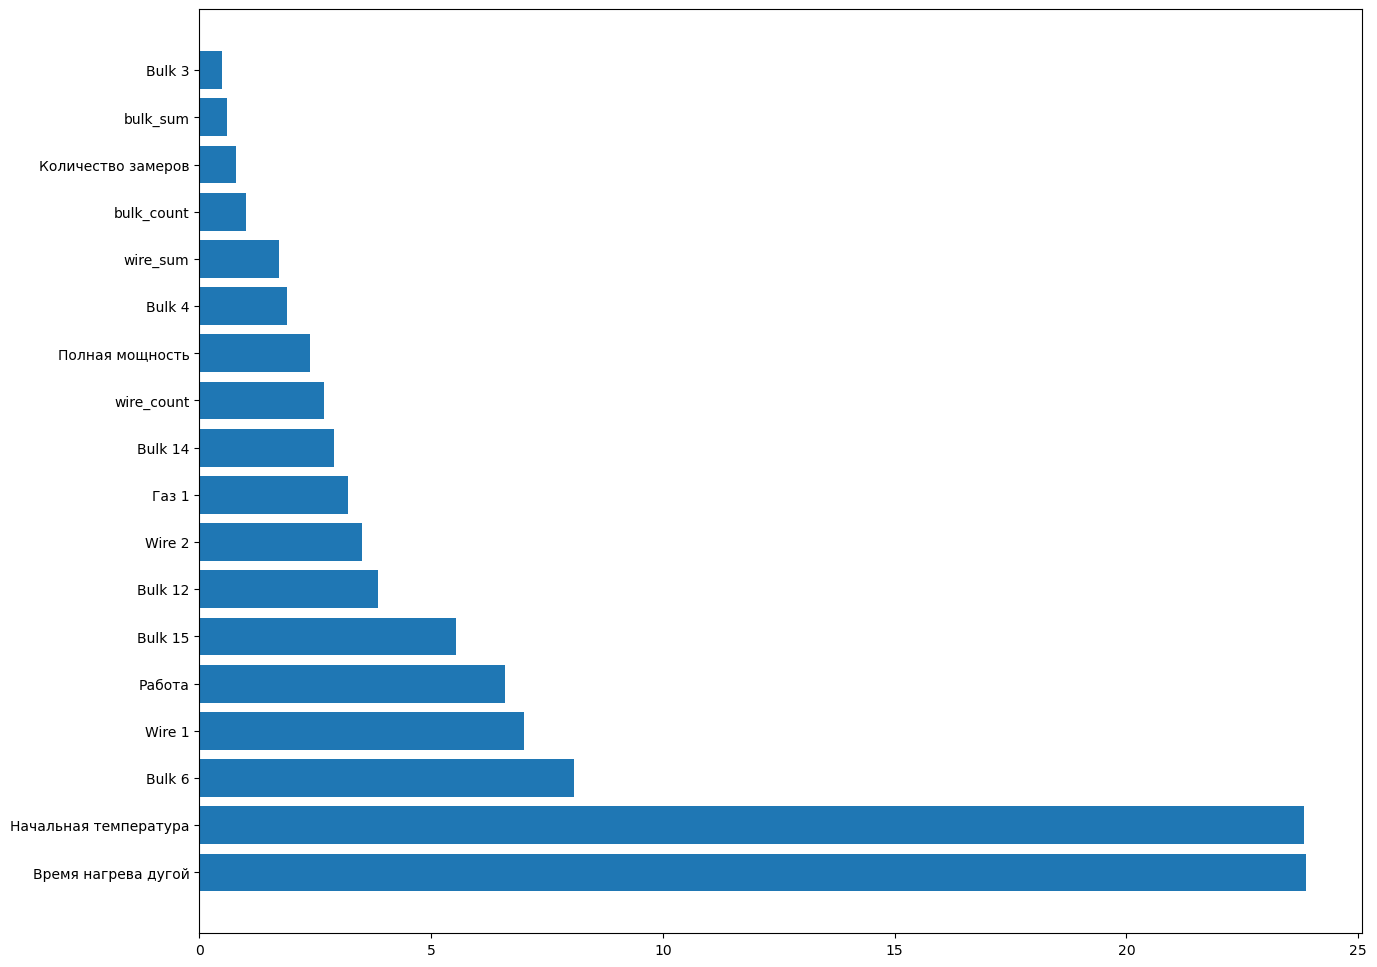

In [178]:
plt.figure(figsize=(15, 12))
plt.barh(importances['feature'], importances['importance'])
plt.show()

Наибольшее влияние на конечную температуру оказывают начальная температура и время нагрева дугой. Также на температуру влияют добавки Bulk 6, 12, 15 и Wire 1, а также работа элетродов.

## Выводы

1. Загружены данные о процессе. Некоторые оказались бесполезны для исследования.
2. Исследованы выбросы. Учитывая особенности производства, удалены были только наиболее выделяющиеся. Подобраны можели, нечувствительные к выбросам.
3. Добавлены дополнительные признаки:
* полная мощность;
* работа электродов;
* общее время нагрева дугой; 
* общий объем сыпучих и проволочных добавок;
* количество видов сыпучих и проволочных материалов.
4. В данных о сыпучих материалах содержится множество пропусков, по всей видимости, соответствующих отсутствию данной добавки в ковше. Пропуски заполнены нулями. 
5. Выделены начальная и конечная температуры
6. Данные объединены в итоговый датафрейм таким образом, что в него не вошли ковши с неполными или ошибочными данными.
7. Подобрана модель машинного обучения со следующими параметрами:
```
CatBoostRegressor{
 'depth': 2,
 'l2_leaf_reg': 6,
 'learning_rate': 0.05,
 'n_estimators': 1000
  }
```  
Значение средней абсолютной ошибки на тестовой выборке составило 6,28°
8. Проанализирована важность признаков для полученной модели, наиболее всего влияющие на конечную температуру процесса:
* Наиболее значимыми оказались начальная температура и время нагрева дугой.
* Также на температуру влияют добавки Bulk 6, 12, 15 и Wire 1, а также работа, произведенная элетродами.
* Наименее значимыми оказались общий объем добавок, количество этапов и видов сыпучих добавок, объем добавок Bulk 3 и 4. 